### Parallelization
- In LangGraph, nodes typically execute in sequence defined by edges, but when the task does not depend on each other's output, we can run them in parallel.
- This is achieved by:
    - Defining multiple nodes that can operate independently
    - Connecting them to a common starting point
    - Merging their outputs into a downstream node, if needed.
#### Benefits of Parallelization:
- Speed: Reduces total execution time by running task concurrently
- Scalability: Handles larger workflows efficiently
- Modularity: Keeps the graph structure clean and reusable

In [1]:
# imports and load LLM
import os
from dotenv import load_dotenv
load_dotenv()
# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
api_key = os.getenv("OPENAI_API_KEY")
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(name="gpt-5-nano", api_key=api_key)
llm.invoke("What is machine learning?")

AIMessage(content='Machine learning is a subset of artificial intelligence that allows computers to learn and improve from data without being explicitly programmed. It uses algorithms and statistical models to analyze and interpret large amounts of data, identifying patterns and making predictions or decisions based on that analysis. Machine learning is used in a variety of applications, such as image and speech recognition, natural language processing, and recommendation systems.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 74, 'prompt_tokens': 12, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CZvqDbOda9XtT1GIXnK4I22ga9HfX', 'service_tier': 'default', 'finish_reason': 'stop', 'log

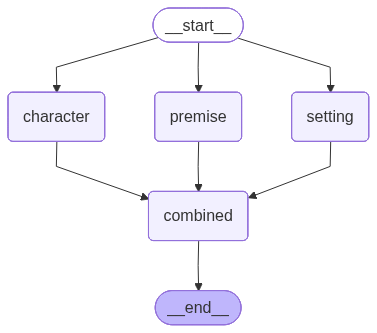

In [3]:
# Define state
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

class State(TypedDict):
    topic: str
    character: str
    premise: str
    setting: str
    final_story: str

# Create nodes
def character(state: State):
    msg = llm.invoke(f"Create two character names and brief traits for a story about {state['topic']}")
    return {'character': msg.content}

def premise(state: State):
    msg = llm.invoke(f"Write one-sentence plot premise for a story about {state['topic']}")
    return {'premise': msg.content}

def setting(state: State):
    msg = llm.invoke(f"Describe a vivid setting for a story about {state['topic']}")
    return {'setting': msg.content}

def combined(state: State):
    msg = llm.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state['character']}\n"
        f"Setting: {state['setting']}\n"
        f"Premise: {state['premise']}\n"
        )
    return {'final_story': msg.content}

# Build graph
graph = StateGraph(State)
graph.add_node("character", character)
graph.add_node("premise", premise)
graph.add_node("setting", setting)
graph.add_node("combined", combined)

# Create edges
graph.add_edge(START, "character")
graph.add_edge(START, "premise")
graph.add_edge(START, "setting")
graph.add_edge("character", "combined")
graph.add_edge("premise", "combined")
graph.add_edge("setting", "combined")
graph.add_edge("combined", END)

# Compile graph
compiled_graph = graph.compile()

# View graph
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [4]:
# Invoke graph
state = {"topic": "Time travel"}
result = compiled_graph.invoke(state)
print(result)

{'topic': 'Time travel', 'character': '1. Dr. Olivia Bennett - Brilliant and ambitious scientist who has dedicated her life to researching time travel and unlocking its mysteries. She is determined, focused, and willing to take risks in pursuit of her goals.\n\n2. Maxwell "Max" Cooper - A charming and rebellious freelance journalist who stumbled upon Dr. Bennett\'s research and becomes entangled in a time-travel experiment gone wrong. He is street-smart, quick-witted, and always up for an adventure.', 'premise': 'A scientist discovers a way to travel through time and uses their newfound ability to try and prevent a catastrophic event from occurring in the future.', 'setting': 'The room was dimly lit with flickering torches lining the stone walls. Dust motes danced in the air, caught in the beams of moonlight that filtered in through narrow windows placed high above. The air was thick with the smell of musty books and ancient parchment. \n\nIn the center of the room stood an elaborate c